In [1]:
!pip install pandas matplotlib seaborn pyarrow

In [12]:
import pandas as pd
import glob
import os

# --- Configuration ---
# Your path (Keep exactly as you have it)
DATA_PATH = r"C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc"

def smart_load_orc(path):
    print(f"Checking path: {path}")
    
    # CASE 1: The path points directly to a single file
    if os.path.isfile(path):
        print("-> Path identifies as a SINGLE FILE.")
        try:
            return pd.read_orc(path)
        except Exception as e:
            raise ValueError(f"Could not read the file. Error: {e}")

    # CASE 2: The path points to a folder
    elif os.path.isdir(path):
        print("-> Path identifies as a FOLDER. Searching for parts...")
        
        # Search for .orc files recursively
        orc_files = glob.glob(os.path.join(path, "**", "*.orc"), recursive=True)
        
        # Fallback for spark 'part-*' files without extension
        if not orc_files:
            print("   No .orc files found inside. Checking for 'part-*'...")
            candidates = glob.glob(os.path.join(path, "**", "part-*"), recursive=True)
            orc_files = [f for f in candidates if os.path.isfile(f) and not f.endswith(".crc") and "_SUCCESS" not in f]
            
        print(f"   Found {len(orc_files)} data parts.")
        
        if not orc_files:
             raise ValueError(f"Directory exists but contains no valid ORC data. Contents: {os.listdir(path)}")

        # Combine parts
        dfs = []
        for file in orc_files:
            try:
                dfs.append(pd.read_orc(file))
            except Exception as e:
                print(f"   Skipping {os.path.basename(file)}: {e}")
        
        if not dfs:
            raise ValueError("Found files but failed to read them.")
            
        return pd.concat(dfs, ignore_index=True)

    # CASE 3: Path does not exist
    else:
        raise FileNotFoundError(f"The path does not exist:\n{path}\nPlease check for typos.")

# --- Execution ---
try:
    df = smart_load_orc(DATA_PATH)
    
    # Process the 'ds' column if it exists
    if 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values('ds').set_index('ds')
        print(f"\nSUCCESS: Data Loaded! Shape: {df.shape}")
        print(df.head())
    else:
        print("\nWARNING: Data loaded, but 'ds' column is missing.")
        print("Columns:", df.columns)

except Exception as e:
    print("\nCRITICAL ERROR:", e)

Checking path: C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc
-> Path identifies as a SINGLE FILE.

SUCCESS: Data Loaded! Shape: (827987, 13)
                     transaction_count total_volume avg_transaction_size  \
ds                                                                         
1991-01-02 07:00:00                  1        68.00            68.000000   
1991-01-02 07:15:00                  2        45.62            22.810000   
1991-01-02 17:30:00                  1       114.73           114.730000   
1991-01-03 09:00:00                  1       251.71           251.710000   
1991-01-03 11:00:00                  1        16.28            16.280000   

                     error_count  fraud_count  avg_debt_ratio  \
ds                                                              
1991-01-02 07:00:00            0            0        0.611185   
1991-01-02 07:15:00            0            0        0.611185   
1991-01-02 17:30:00            0    

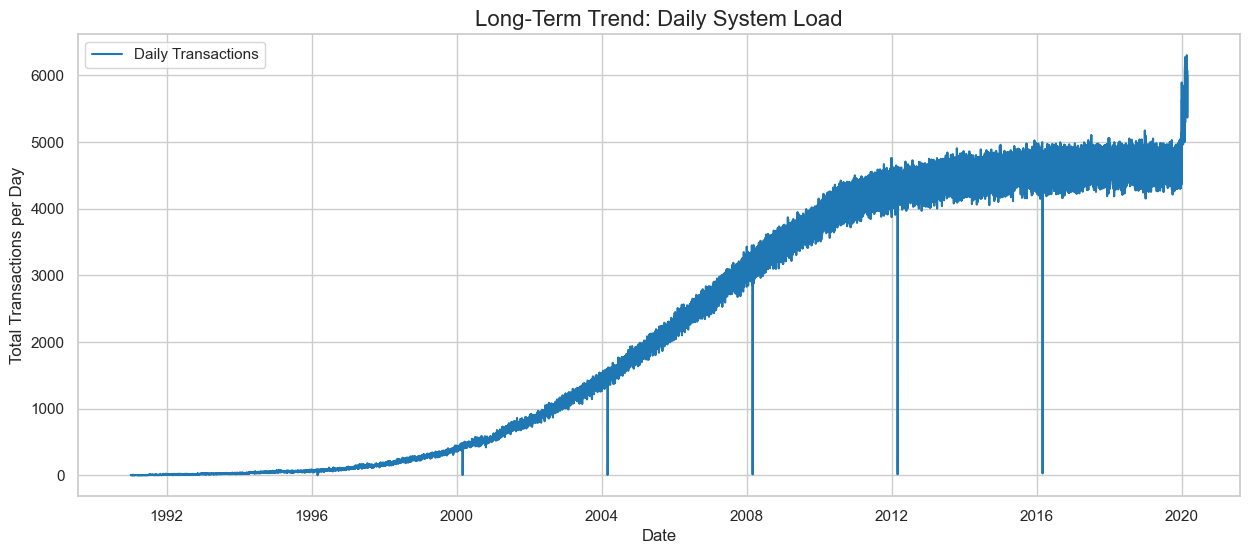

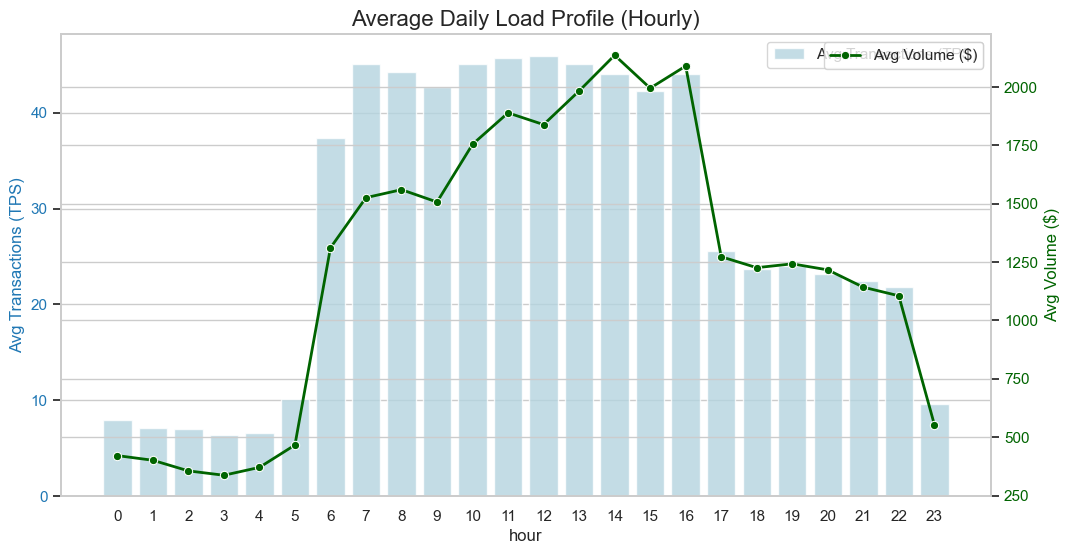

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# --- 1. Daily Trend (Long Term) ---
plt.figure(figsize=(15, 6))
# Resample to Daily Sums to clean up the noise
daily_load = df['transaction_count'].resample('D').sum()

plt.plot(daily_load, label='Daily Transactions', color='#1f77b4', linewidth=1.5)
plt.title('Long-Term Trend: Daily System Load', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Transactions per Day')
plt.legend()
plt.show()

# --- 2. Hourly Profile (Intraday Seasonality) ---
# Create 'hour' column for grouping
df['hour'] = df.index.hour
hourly_profile = df.groupby('hour')[['transaction_count', 'total_volume']].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart: Transaction Count (Left Axis) - Shows "Busyness"
sns.barplot(x=hourly_profile.index, y=hourly_profile['transaction_count'], 
            ax=ax1, color='lightblue', alpha=0.8, label='Avg Transactions (TPS)')
ax1.set_ylabel('Avg Transactions (TPS)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Line Chart: Total Volume (Right Axis) - Shows "Money Moved"
ax2 = ax1.twinx()
sns.lineplot(x=hourly_profile.index, y=hourly_profile['total_volume'], 
             ax=ax2, color='darkgreen', marker='o', linewidth=2, label='Avg Volume ($)')
ax2.set_ylabel('Avg Volume ($)', color='darkgreen', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkgreen')

plt.title('Average Daily Load Profile (Hourly)', fontsize=16)
plt.show()

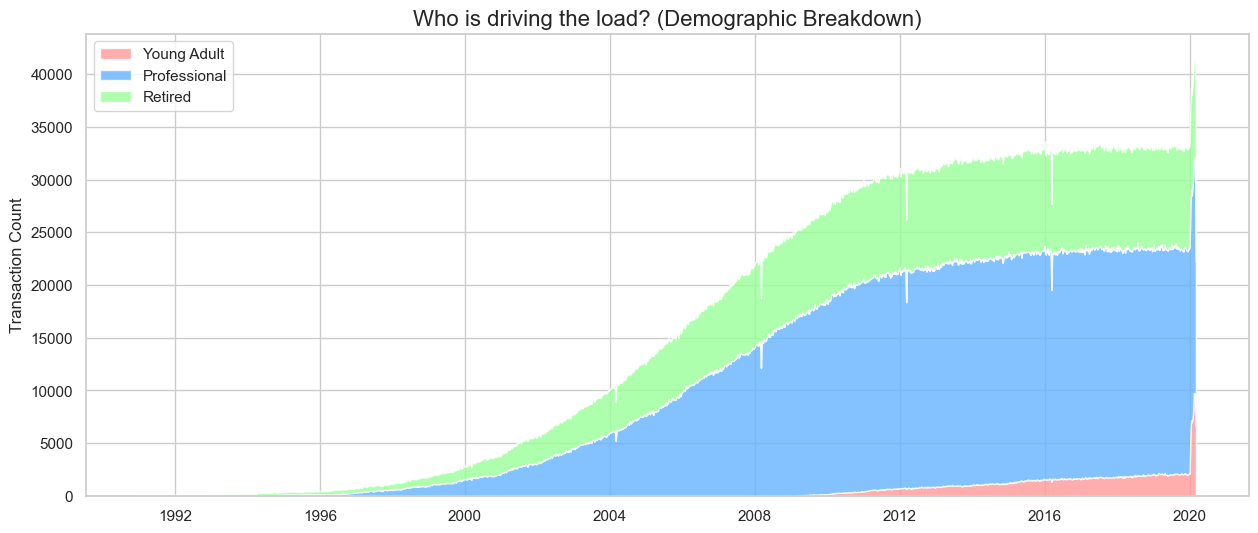

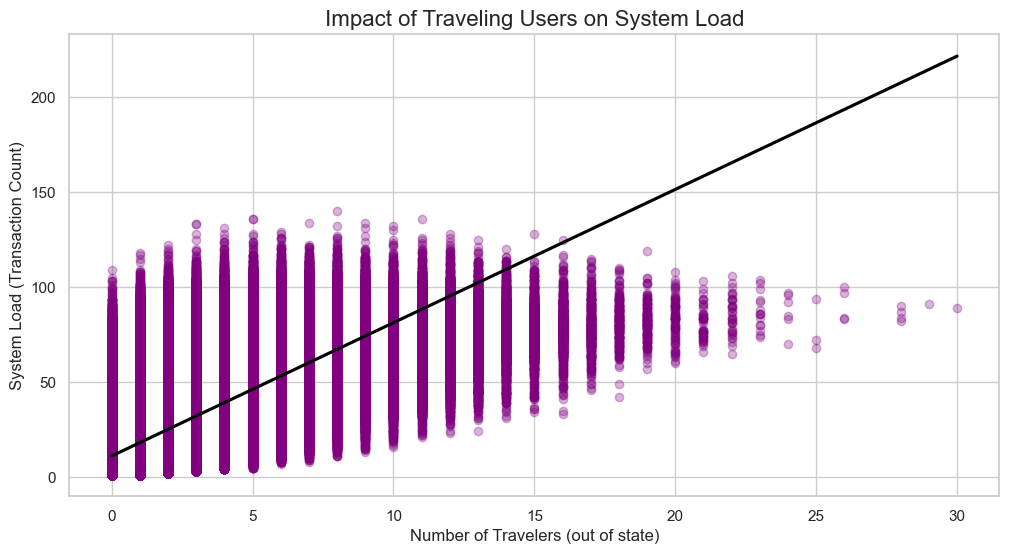

In [14]:
# --- 1. Life Stage Contribution (Stacked Area) ---
# We use Weekly sums to make the chart readable
demographic_cols = ['cnt_young_adult', 'cnt_professional', 'cnt_retired']

if all(col in df.columns for col in demographic_cols):
    weekly_demo = df[demographic_cols].resample('W').sum()
    
    plt.figure(figsize=(15, 6))
    plt.stackplot(weekly_demo.index, 
                  weekly_demo['cnt_young_adult'], 
                  weekly_demo['cnt_professional'], 
                  weekly_demo['cnt_retired'],
                  labels=['Young Adult', 'Professional', 'Retired'],
                  colors=['#ff9999','#66b3ff','#99ff99'], 
                  alpha=0.8)
    
    plt.legend(loc='upper left')
    plt.title('Who is driving the load? (Demographic Breakdown)', fontsize=16)
    plt.ylabel('Transaction Count')
    plt.show()
else:
    print("Skipping Demographic Chart: Columns not found.")

# --- 2. Impact of Travelers ---
if 'traveller_count' in df.columns:
    plt.figure(figsize=(12, 6))
    
    # Scatter plot with regression line
    sns.regplot(data=df, x='traveller_count', y='transaction_count', 
                scatter_kws={'alpha':0.3, 'color':'purple'}, line_kws={'color':'black'})
    
    plt.title('Impact of Traveling Users on System Load', fontsize=16)
    plt.xlabel('Number of Travelers (out of state)')
    plt.ylabel('System Load (Transaction Count)')
    plt.grid(True)
    plt.show()

C:\Users\Saurav Dani\AppData\Local\Temp\ipykernel_21596\1040506832.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['transaction_count'].resample('H').sum()


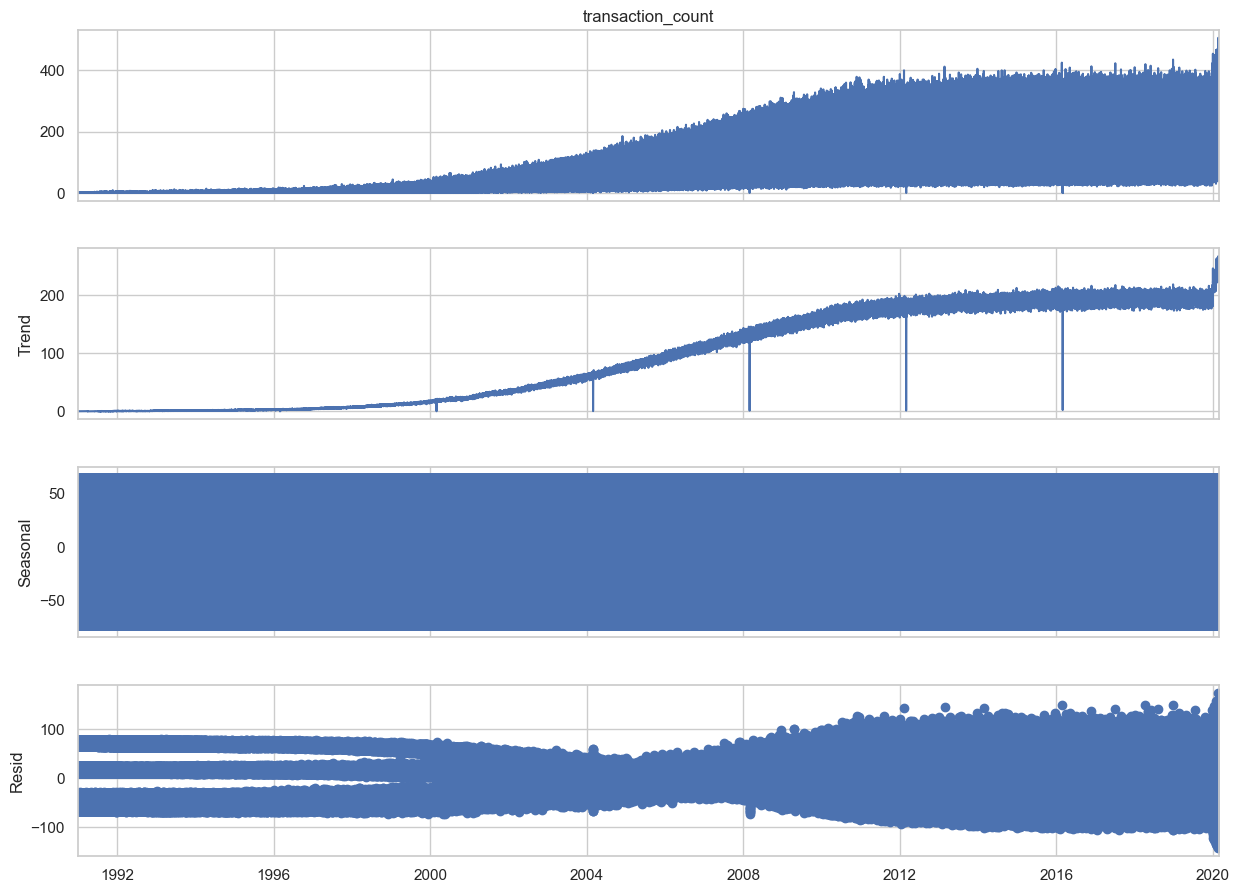

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Prepare Data
# We resample to Hourly to make decomposition cleaner (15-min data can be too noisy)
df_hourly = df['transaction_count'].resample('H').sum()

# 2. Decompose
# period=24 means we are looking for a DAILY cycle (24 hours)
decomposition = seasonal_decompose(df_hourly, model='additive', period=24)

# 3. Plot
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

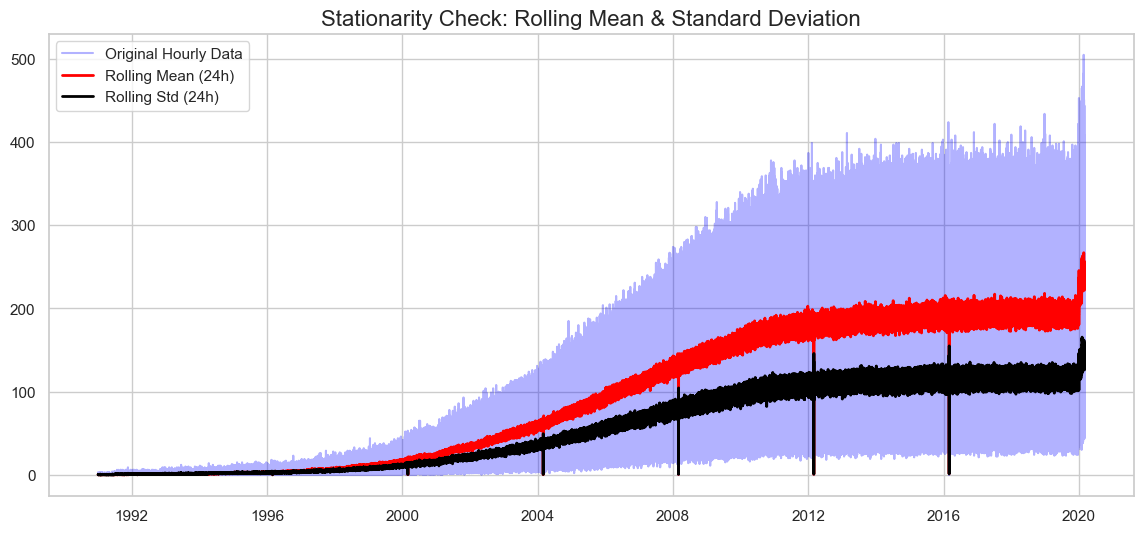

In [16]:
# Calculate Rolling Statistics (Window = 24 hours)
rolling_mean = df_hourly.rolling(window=24).mean()
rolling_std = df_hourly.rolling(window=24).std()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_hourly, color='blue', label='Original Hourly Data', alpha=0.3)
plt.plot(rolling_mean, color='red', label='Rolling Mean (24h)', linewidth=2)
plt.plot(rolling_std, color='black', label='Rolling Std (24h)', linewidth=2)
plt.legend(loc='best')
plt.title('Stationarity Check: Rolling Mean & Standard Deviation', fontsize=16)
plt.show()

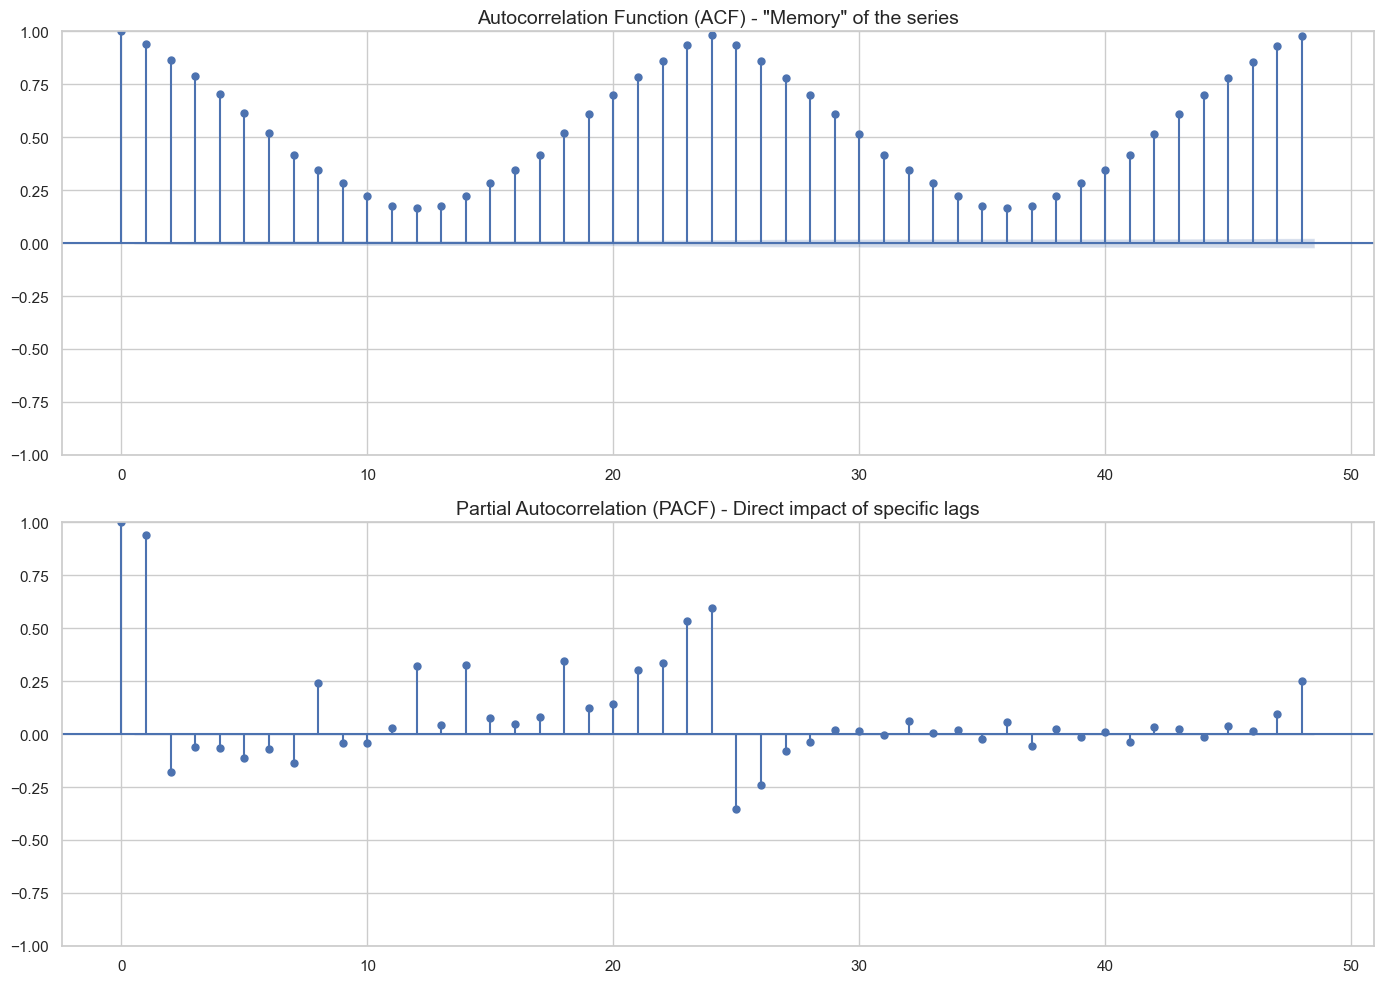

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. ACF (Autocorrelation Function)
# Shows correlation with past lags. We look at 48 hours (2 days) back.
plot_acf(df_hourly, lags=48, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) - "Memory" of the series', fontsize=14)

# 2. PACF (Partial Autocorrelation Function)
# Shows direct correlation after removing intermediate lags.
plot_pacf(df_hourly, lags=48, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) - Direct impact of specific lags', fontsize=14)

plt.tight_layout()
plt.show()

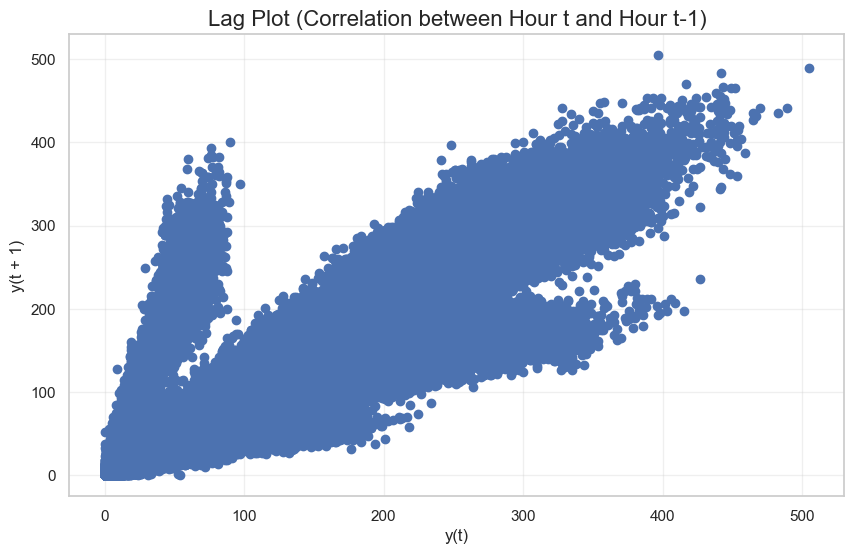

In [18]:
from pandas.plotting import lag_plot

plt.figure(figsize=(10, 6))

# Plot t vs t-1 (Previous Hour)
lag_plot(df_hourly, lag=1)

plt.title('Lag Plot (Correlation between Hour t and Hour t-1)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()